In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
cd ..

/home/rd804/discriminator-metric


In [13]:
tests =[ {'exp_name': 'trial_1_ln_jetnet30',
          'best_epoch': 0,
          'type': 'lorentznet'},
           {'exp_name': 'trial_1_pn_jetnet30',
          'best_epoch': 'best_model_score',
          'type': 'particlenet'},
           {'exp_name': 'trial_1_remove_tail_PN',
          'best_epoch': 'best_model_score',
          'type': 'particlenet'},
           {'exp_name': 'test_cartesian_1',
            'best_epoch': 3,
          'type': 'lorentznet'} ]


In [10]:

label = pd.read_hdf('data/jetnet30_data.h5', 'labels_valid')['labels'].values
print(label.shape)



(100000,)


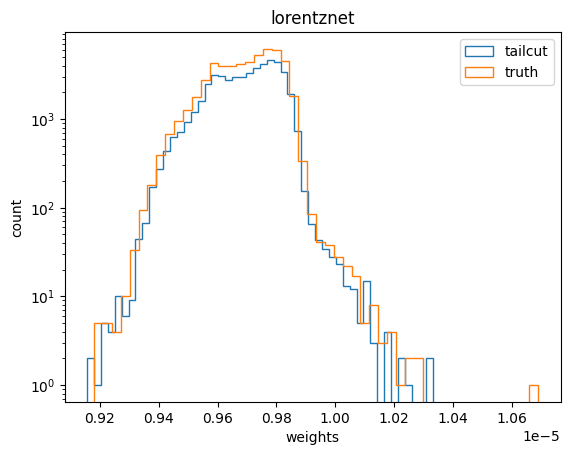

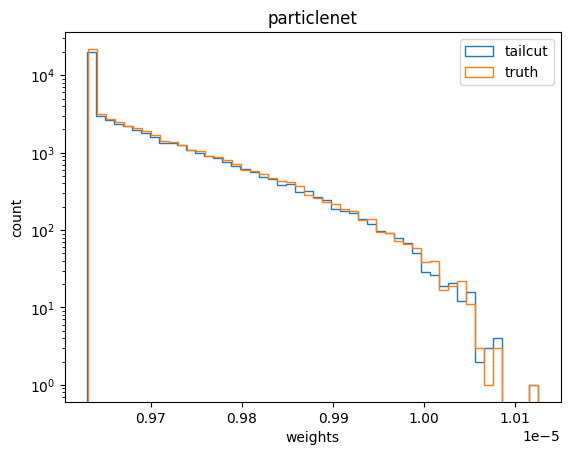

IndexError: boolean index did not match indexed array along dimension 0; dimension is 52158 but corresponding boolean dimension is 103176

In [71]:
for test in tests:
    exp_name = test['exp_name']
    best_epoch = test['best_epoch']
    if test['type']=='lorentznet':
        score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')[:,2]
    elif test['type']=='particlenet':
        score = np.load(f'output/{exp_name}/best_model_score.npy')[:,1]

    weights = score/(1-score)
    weights = weights/np.sum(weights)
    plt.hist(weights[label==0], bins=50,histtype='step', label='tailcut')
    plt.hist(weights[label==1], bins=50,histtype='step', label='truth')
    plt.legend()
    plt.xlabel('weights')
    plt.ylabel('count')
    plt.yscale('log')
    plt.title(test['type'])
    plt.show()


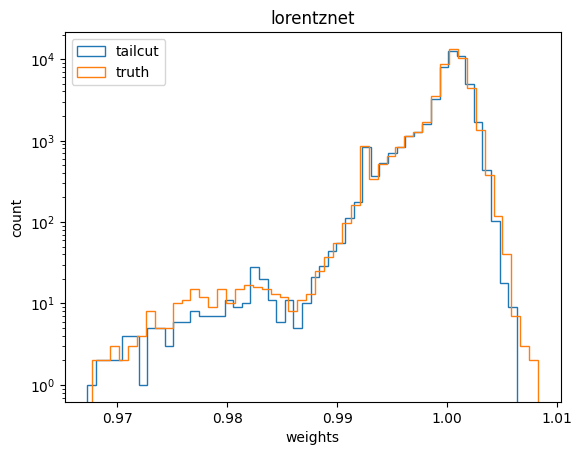

In [33]:
test = tests[-1]

exp_name = test['exp_name']
best_epoch = test['best_epoch']
score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')

weights = score[:,2]/(1-score[:,2])
plt.hist(weights[score[:,0]==0], bins=50,histtype='step', label='tailcut')
plt.hist(weights[score[:,0]==1], bins=50,histtype='step', label='truth')

plt.xlabel('weights')
plt.ylabel('count')
plt.yscale('log')
plt.legend(loc='upper left')
#plt.xscale('log')
#plt.xlim(0.1,10)
plt.title(test['type'])
plt.show()

array([1., 1., 1., ..., 0., 0., 1.], dtype=float32)